In [1]:
!pip install mediapipe==0.10.9 opencv-python numpy==1.23.5 matplotlib scikit-learn

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/50.5 MB ? eta -:--:--
   - -------------------------------------- 2.4/50.5 MB 15.0 MB/s eta 0:00:04
   ----- ---------------------------------- 6.8/50.5 MB 19.1 MB/s eta 0:00:03
   -------- ------------------------------- 10.5/50.5 MB 17.7 MB/s eta 0:00:03
   ---------- ----------------------------- 13.9/50.5 MB 17.5 MB/s eta 0:00:03
   -------------- ------------------------- 18.1/50.5 MB 17.6 MB/s eta 0:00:

# Real Time Trial

In [1]:
# Skeleton extraction + save (.npy) — robust version
# Works for nested folder structures. Saves no_aug and optional aug versions.

import os
import cv2
import numpy as np
from tqdm import tqdm

# --------- CONFIG ----------
input_dir = r"C:\Users\SATYAM\Downloads\ssbd_dataset\ssbd2"  
output_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed_new"     
no_aug_dir = os.path.join(output_dir, "no_aug")
aug_dir = os.path.join(output_dir, "aug")
os.makedirs(no_aug_dir, exist_ok=True)
os.makedirs(aug_dir, exist_ok=True)

TARGET_FRAMES = 150   # number of timesteps per sample (must match training)
NUM_KEYPOINTS = 33    # MediaPipe Pose landmarks count
COORDS = 2            # x,y
AUGMENT = True        # set False to skip augment folder saving

try:
    import mediapipe as mp
except Exception as e:
    raise ImportError("mediapipe is required. Install with `pip install mediapipe` and re-run. Error: " + str(e))

mp_pose = mp.solutions.pose
# initialize once and reuse
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

def sample_frame_indices(total_frames, target_frames):
    if total_frames <= 0:
        return np.array([], dtype=int)
    if total_frames <= target_frames:
        # take all frames (will pad later)
        return np.arange(total_frames)
    # evenly spaced indices across the whole video
    return np.linspace(0, total_frames - 1, target_frames, dtype=int)

def extract_skeleton_sequence(video_path, target_frames=TARGET_FRAMES):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        cap.release()
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    indices = sample_frame_indices(total_frames, target_frames)

    seq = []
    frame_idx = 0
    indices_set = set(indices.tolist())
    # read frames sequentially and process only sampled ones
    success = True
    while success and (len(indices_set) > 0 or frame_idx <= (indices[-1] if len(indices)>0 else -1)):
        success, frame = cap.read()
        if not success:
            break
        if frame_idx in indices_set:
            # process this frame
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb)
            if results.pose_landmarks:
                kp = [[lm.x, lm.y] for lm in results.pose_landmarks.landmark[:NUM_KEYPOINTS]]
                # ensure shape exactly NUM_KEYPOINTS x COORDS
                kp = np.array(kp, dtype=np.float32)
            else:
                kp = np.zeros((NUM_KEYPOINTS, COORDS), dtype=np.float32)
            seq.append(kp)
            indices_set.remove(frame_idx)
        frame_idx += 1

    cap.release()

    # If we didn't get enough sampled frames (e.g., very short video), pad by repeating last available or zeros
    if len(seq) == 0:
        return None  # completely failed (no frames or no landmarks in any sampled frame)

    # pad or trim to exact length
    seq = np.array(seq, dtype=np.float32)
    if seq.shape[0] > target_frames:
        seq = seq[:target_frames]
    elif seq.shape[0] < target_frames:
        last = seq[-1]
        pad_count = target_frames - seq.shape[0]
        padding = np.zeros((pad_count, NUM_KEYPOINTS, COORDS), dtype=np.float32)
        padding[:] = last  # repeat last frame for smoother pad
        seq = np.concatenate([seq, padding], axis=0)

    return seq  # shape (target_frames, NUM_KEYPOINTS, COORDS)


def normalize_skeleton(seq):
    mean = np.mean(seq, axis=(0,1))
    std = np.std(seq, axis=(0,1)) + 1e-8
    return (seq - mean) / std


def augment_skeleton(seq):
    aug_list = []
    # mirrored (flip x)
    mirrored = seq.copy()
    mirrored[:, :, 0] *= -1
    aug_list.append(mirrored)
    # temporal jitter: small random roll
    shift = np.random.randint(-5, 6)
    jitter = np.roll(seq, shift=shift, axis=0)
    aug_list.append(jitter)
    # gaussian noise
    noise = seq + np.random.normal(0, 0.03, seq.shape).astype(np.float32)
    aug_list.append(noise)
    return aug_list


saved_count = 0
skipped_count = 0
failed_files = []

# build a list of video files first (robust)
video_exts = ('.mp4', '.avi', '.mov', '.mkv', '.MP4', '.AVI')

video_paths = []
for root, dirs, files in os.walk(input_dir):
    for f in files:
        if f.endswith(video_exts):
            video_paths.append(os.path.join(root, f))

print(f"Found {len(video_paths)} video files under '{input_dir}' — starting extraction...")

for vpath in tqdm(video_paths):
    # class is the first path component under input_dir
    rel = os.path.relpath(vpath, input_dir)
    parts = rel.split(os.sep)
    class_name = parts[0] if len(parts) > 1 else "unknown"
    # create class subdirs in outputs
    out_no_aug_class = os.path.join(no_aug_dir, class_name)
    out_aug_class = os.path.join(aug_dir, class_name)
    os.makedirs(out_no_aug_class, exist_ok=True)
    os.makedirs(out_aug_class, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(vpath))[0]

    try:
        seq = extract_skeleton_sequence(vpath, TARGET_FRAMES)
        if seq is None:
            skipped_count += 1
            failed_files.append(vpath)
            # print(f"Skipped (no landmarks): {vpath}")
            continue

        # normalize
        seq = normalize_skeleton(seq)

        # save no_aug
        save_no_aug = os.path.join(out_no_aug_class, f"{base_name}.npy")
        np.save(save_no_aug, seq)
        saved_count += 1

        # save augmentations 
        if AUGMENT:
            aug_seqs = augment_skeleton(seq)
            for i, aseq in enumerate(aug_seqs, start=1):
                save_aug = os.path.join(out_aug_class, f"{base_name}_aug{i}.npy")
                np.save(save_aug, aseq)

    except Exception as e:
        skipped_count += 1
        failed_files.append((vpath, str(e)))
        # continue processing others

print("=== Summary ===")
print("Saved (no_aug)     :", saved_count)
print("Skipped / failed   :", skipped_count)
if failed_files:
    print("Example failed file(s):", failed_files[:5])
print("Processed data saved to:", output_dir)


pose.close()

Found 289 video files under 'C:\Users\SATYAM\Downloads\ssbd_dataset\ssbd2' — starting extraction...


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [47:45<00:00,  9.92s/it]

=== Summary ===
Saved (no_aug)     : 289
Skipped / failed   : 0
Processed data saved to: C:\Users\SATYAM\Downloads\ssbd_processed_new


In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed_new"
no_aug_dir = os.path.join(base_dir, "no_aug")
aug_dir = os.path.join(base_dir, "aug")

def load_npy_data(folder):
    X, y = [], []
    for cls in os.listdir(folder):
        class_folder = os.path.join(folder, cls)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                path = os.path.join(class_folder, file)
                X.append(np.load(path))
                y.append(cls)
    return np.array(X), np.array(y)

# Load both no_aug and aug data
X_no_aug, y_no_aug = load_npy_data(no_aug_dir)
X_aug, y_aug = load_npy_data(aug_dir)

# Combine both
X = np.concatenate([X_no_aug, X_aug], axis=0)
y = np.concatenate([y_no_aug, y_aug], axis=0)

print("Total samples:", X.shape[0])
print("Data shape:", X.shape, "| Labels shape:", y.shape)

# Flatten coordinates for GRU input 
X = X.reshape(X.shape[0], X.shape[1], X.shape[2] * X.shape[3])

# Encode class labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes:", encoder.classes_)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Total samples: 1156
Data shape: (1156, 150, 33, 2) | Labels shape: (1156,)
Classes: ['Action_videos' 'Still_videos' 'armFlapping' 'headBanging' 'spinning']
Train: (924, 150, 66), Test: (232, 150, 66)


Epoch 1/40
47/47 [==============================] - 21s 199ms/step - loss: 1.5278 - accuracy: 0.3559 - val_loss: 1.2873 - val_accuracy: 0.4703
Epoch 2/40
47/47 [==============================] - 6s 126ms/step - loss: 1.2703 - accuracy: 0.4993 - val_loss: 1.1338 - val_accuracy: 0.5081
Epoch 3/40
47/47 [==============================] - 6s 135ms/step - loss: 1.1060 - accuracy: 0.5697 - val_loss: 0.9802 - val_accuracy: 0.6054
Epoch 4/40
47/47 [==============================] - 6s 136ms/step - loss: 0.9636 - accuracy: 0.6035 - val_loss: 0.8384 - val_accuracy: 0.6378
Epoch 5/40
47/47 [==============================] - 6s 127ms/step - loss: 0.8082 - accuracy: 0.6888 - val_loss: 0.7171 - val_accuracy: 0.6865
Epoch 6/40
47/47 [==============================] - 6s 128ms/step - loss: 0.6659 - accuracy: 0.7361 - val_loss: 0.6379 - val_accuracy: 0.7351
Epoch 7/40
47/47 [==============================] - 7s 149ms/step - loss: 0.5795 - accuracy: 0.7781 - val_loss: 0.5902 - val_accuracy: 0.7459
Epoch

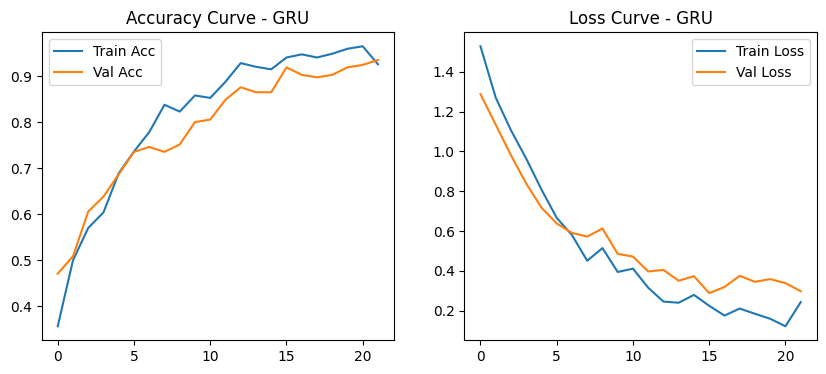

8/8 [==============================] - 3s 42ms/step


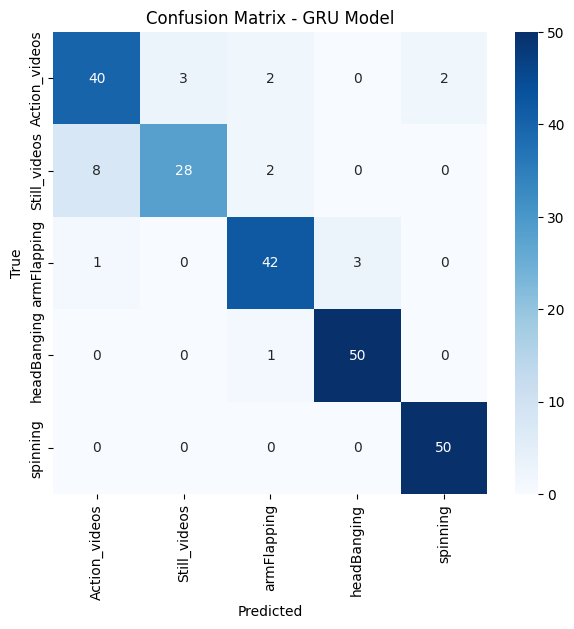


Classification Report:

               precision    recall  f1-score   support

Action_videos       0.82      0.85      0.83        47
 Still_videos       0.90      0.74      0.81        38
  armFlapping       0.89      0.91      0.90        46
  headBanging       0.94      0.98      0.96        51
     spinning       0.96      1.00      0.98        50

     accuracy                           0.91       232
    macro avg       0.90      0.90      0.90       232
 weighted avg       0.91      0.91      0.90       232

💾 Model saved as gru_asd_neutral_model.h5


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Model Definition
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    GRU(64, kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


# Compile Model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


# Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


# Evaluate on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"🧪 Final Test Accuracy: {test_acc*100:.2f}%")


# Plot Training Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - GRU")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - GRU")
plt.legend()
plt.show()


# Confusion Matrix + Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
classes = encoder.classes_

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=classes))


# Save Model
model.save("gru_asd_neutral_model.h5")
print("💾 Model saved as gru_asd_neutral_model.h5")

Epoch 1/40
47/47 [==============================] - 12s 162ms/step - loss: 1.3908 - accuracy: 0.4235 - val_loss: 1.1004 - val_accuracy: 0.5622
Epoch 2/40
47/47 [==============================] - 6s 119ms/step - loss: 1.0744 - accuracy: 0.5846 - val_loss: 0.9302 - val_accuracy: 0.6541
Epoch 3/40
47/47 [==============================] - 6s 119ms/step - loss: 0.9049 - accuracy: 0.6360 - val_loss: 0.7292 - val_accuracy: 0.6865
Epoch 4/40
47/47 [==============================] - 6s 120ms/step - loss: 0.7051 - accuracy: 0.7199 - val_loss: 0.7294 - val_accuracy: 0.7081
Epoch 5/40
47/47 [==============================] - 6s 124ms/step - loss: 0.6116 - accuracy: 0.7713 - val_loss: 0.7109 - val_accuracy: 0.7676
Epoch 6/40
47/47 [==============================] - 6s 126ms/step - loss: 0.5853 - accuracy: 0.7862 - val_loss: 0.5846 - val_accuracy: 0.7838
Epoch 7/40
47/47 [==============================] - 6s 127ms/step - loss: 0.4805 - accuracy: 0.8336 - val_loss: 0.5158 - val_accuracy: 0.7784
Epoch

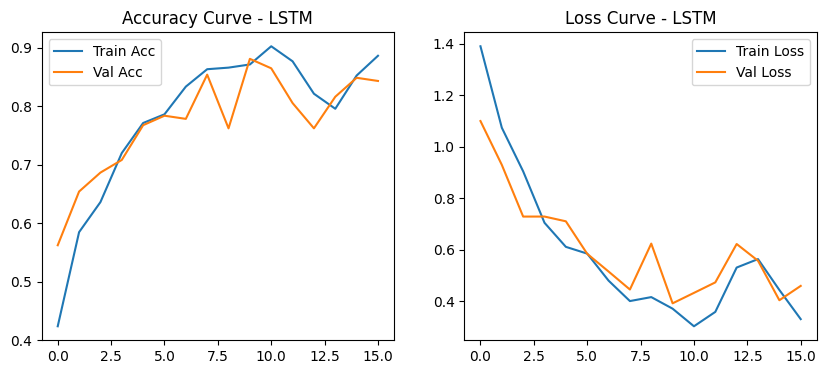

8/8 [==============================] - 2s 46ms/step


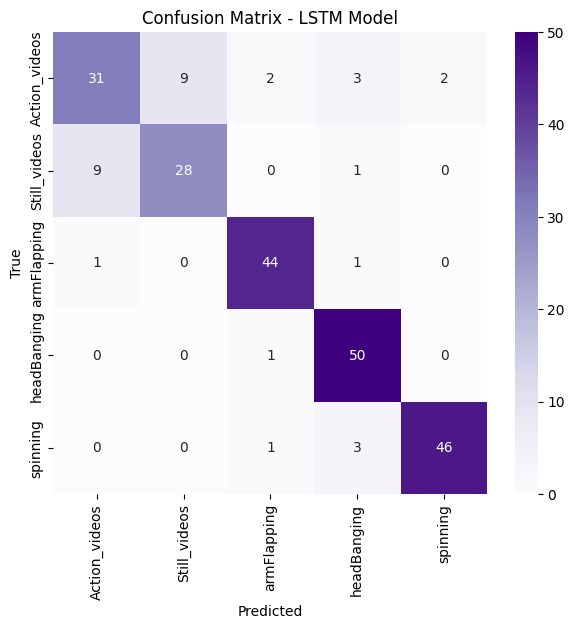


Classification Report:

               precision    recall  f1-score   support

Action_videos       0.76      0.66      0.70        47
 Still_videos       0.76      0.74      0.75        38
  armFlapping       0.92      0.96      0.94        46
  headBanging       0.86      0.98      0.92        51
     spinning       0.96      0.92      0.94        50

     accuracy                           0.86       232
    macro avg       0.85      0.85      0.85       232
 weighted avg       0.85      0.86      0.85       232

💾 Model saved as lstm_asd_neutral_model.h5


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Model Definition
lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    LSTM(64, kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


# Compile Model
lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


# Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


# Evaluate
test_loss, test_acc = lstm_model.evaluate(X_test, y_test_cat)
print(f"🧪 Final Test Accuracy (LSTM): {test_acc*100:.2f}%")


# Plot Accuracy and Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - LSTM")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - LSTM")
plt.legend()
plt.show()


# Confusion Matrix + Report
y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
classes = encoder.classes_

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LSTM Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=classes))

# Save Model
lstm_model.save("lstm_asd_neutral_model.h5")
print("💾 Model saved as lstm_asd_neutral_model.h5")


✅ Data loaded successfully!
Train shape: (924, 150, 66) | Test shape: (232, 150, 66)
Unique classes: [0 1 2 3 4]
Epoch 1/40
58/58 [==============================] - ETA: 0s - loss: 2.5457 - accuracy: 0.3420
Epoch 1: val_accuracy improved from -inf to 0.52586, saving model to bilstm_best_model.keras
58/58 [==============================] - 61s 631ms/step - loss: 2.5457 - accuracy: 0.3420 - val_loss: 2.1380 - val_accuracy: 0.5259 - lr: 5.0000e-04
Epoch 2/40
58/58 [==============================] - ETA: 0s - loss: 1.9249 - accuracy: 0.5649
Epoch 2: val_accuracy improved from 0.52586 to 0.68103, saving model to bilstm_best_model.keras
58/58 [==============================] - 33s 563ms/step - loss: 1.9249 - accuracy: 0.5649 - val_loss: 1.8230 - val_accuracy: 0.6810 - lr: 5.0000e-04
Epoch 3/40
58/58 [==============================] - ETA: 0s - loss: 1.6738 - accuracy: 0.6602
Epoch 3: val_accuracy improved from 0.68103 to 0.72845, saving model to bilstm_best_model.keras
58/58 [===============

58/58 [==============================] - 31s 527ms/step - loss: 0.6193 - accuracy: 0.9827 - val_loss: 0.7480 - val_accuracy: 0.9526 - lr: 2.5000e-04
Epoch 27/40
58/58 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.9773
Epoch 27: val_accuracy did not improve from 0.95259
58/58 [==============================] - 31s 536ms/step - loss: 0.6140 - accuracy: 0.9773 - val_loss: 0.7900 - val_accuracy: 0.9440 - lr: 2.5000e-04
Epoch 28/40
58/58 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.9784
Epoch 28: val_accuracy did not improve from 0.95259
58/58 [==============================] - 31s 527ms/step - loss: 0.6079 - accuracy: 0.9784 - val_loss: 0.7456 - val_accuracy: 0.9353 - lr: 2.5000e-04
Epoch 29/40
58/58 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.9784
Epoch 29: val_accuracy did not improve from 0.95259
58/58 [==============================] - 31s 534ms/step - loss: 0.5985 - accuracy: 0.9784 - val_loss: 0.7439 - v

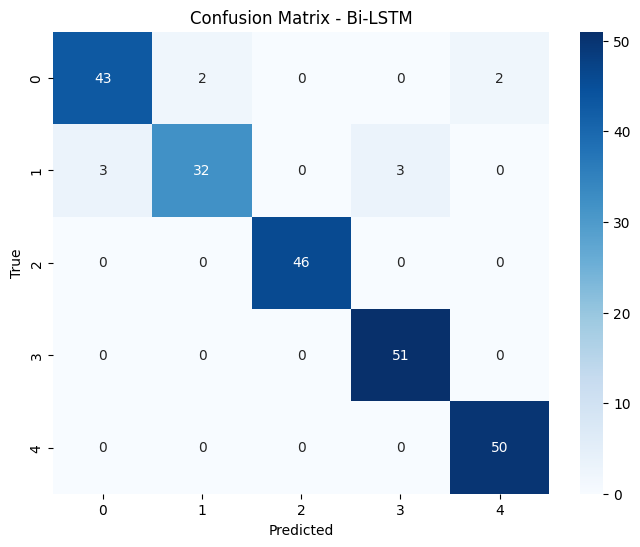


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        47
           1       0.94      0.84      0.89        38
           2       1.00      1.00      1.00        46
           3       0.94      1.00      0.97        51
           4       0.96      1.00      0.98        50

    accuracy                           0.96       232
   macro avg       0.96      0.95      0.95       232
weighted avg       0.96      0.96      0.96       232



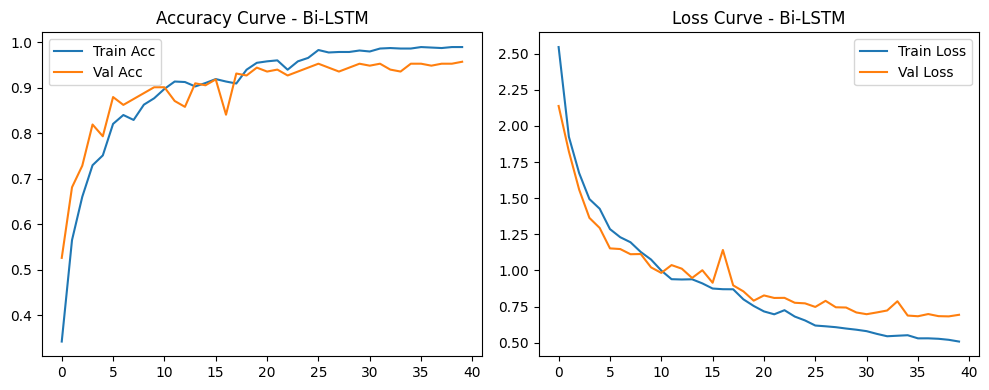

💾 Model saved as BiLSTM_asd_behavior_model.h5


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Load processed data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print("✅ Data loaded successfully!")
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Unique classes: {np.unique(y_train)}")


# Encode class labels
le = LabelEncoder()
y_train_enc = tf.keras.utils.to_categorical(le.fit_transform(y_train))
y_test_enc = tf.keras.utils.to_categorical(le.transform(y_test))

num_classes = y_train_enc.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2])


# Build BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=input_shape),
    Dropout(0.4),
    BatchNormalization(),

    Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'bilstm_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


# Train Model
history = model.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=40,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)


# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


# Confusion Matrix + Classification Report
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# ✅ Fix: convert label classes to strings
classes = [str(c) for c in le.classes_]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Bi-LSTM")
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


# Plot Training Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - Bi-LSTM")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - Bi-LSTM")
plt.legend()
plt.tight_layout()
plt.show()

# Save Model
model.save("BiLSTM_asd_behavior_model.h5")
print("💾 Model saved as BiLSTM_asd_behavior_model.h5")

✅ Data loaded successfully!
Train shape: (924, 150, 66) | Test shape: (232, 150, 66)
Unique classes in training data: [0 1 2 3 4]

Detected Classes: ['0', '1', '2', '3', '4']
Number of classes: 5
Epoch 1/40
58/58 [==============================] - ETA: 0s - loss: 1.9257 - accuracy: 0.3929
Epoch 1: val_accuracy improved from -inf to 0.53879, saving model to cnn_lstm_best_model.keras
58/58 [==============================] - 8s 59ms/step - loss: 1.9257 - accuracy: 0.3929 - val_loss: 1.6959 - val_accuracy: 0.5388 - lr: 5.0000e-04
Epoch 2/40
57/58 [============================>.] - ETA: 0s - loss: 1.5304 - accuracy: 0.5241
Epoch 2: val_accuracy improved from 0.53879 to 0.62069, saving model to cnn_lstm_best_model.keras
58/58 [==============================] - 3s 50ms/step - loss: 1.5283 - accuracy: 0.5227 - val_loss: 1.4130 - val_accuracy: 0.6207 - lr: 5.0000e-04
Epoch 3/40
58/58 [==============================] - ETA: 0s - loss: 1.3465 - accuracy: 0.6180
Epoch 3: val_accuracy improved from

Epoch 26/40
57/58 [============================>.] - ETA: 0s - loss: 0.4988 - accuracy: 0.9496
Epoch 26: val_accuracy did not improve from 0.93966
58/58 [==============================] - 2s 36ms/step - loss: 0.4994 - accuracy: 0.9491 - val_loss: 0.5863 - val_accuracy: 0.9181 - lr: 6.2500e-05
Epoch 27/40
58/58 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.9578
Epoch 27: val_accuracy did not improve from 0.93966
58/58 [==============================] - 2s 39ms/step - loss: 0.4875 - accuracy: 0.9578 - val_loss: 0.5983 - val_accuracy: 0.9267 - lr: 6.2500e-05
Epoch 28/40
57/58 [============================>.] - ETA: 0s - loss: 0.4662 - accuracy: 0.9638Restoring model weights from the end of the best epoch: 22.

Epoch 28: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 28: val_accuracy did not improve from 0.93966
58/58 [==============================] - 2s 42ms/step - loss: 0.4678 - accuracy: 0.9632 - val_loss: 0.5822 - val_accuracy: 0.92

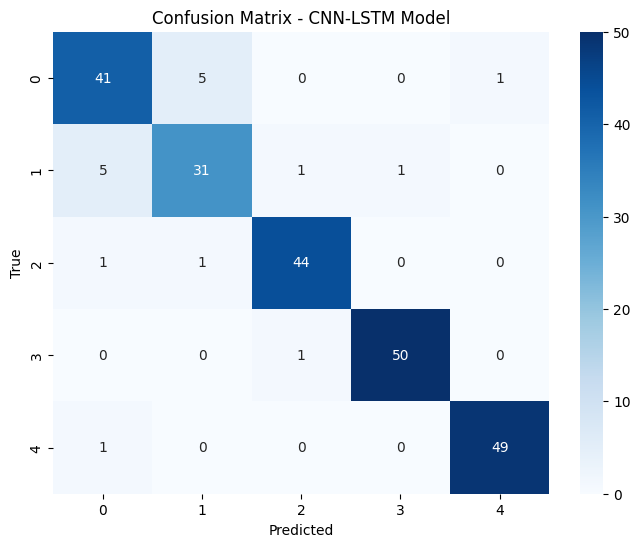


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.84      0.82      0.83        38
           2       0.96      0.96      0.96        46
           3       0.98      0.98      0.98        51
           4       0.98      0.98      0.98        50

    accuracy                           0.93       232
   macro avg       0.92      0.92      0.92       232
weighted avg       0.93      0.93      0.93       232



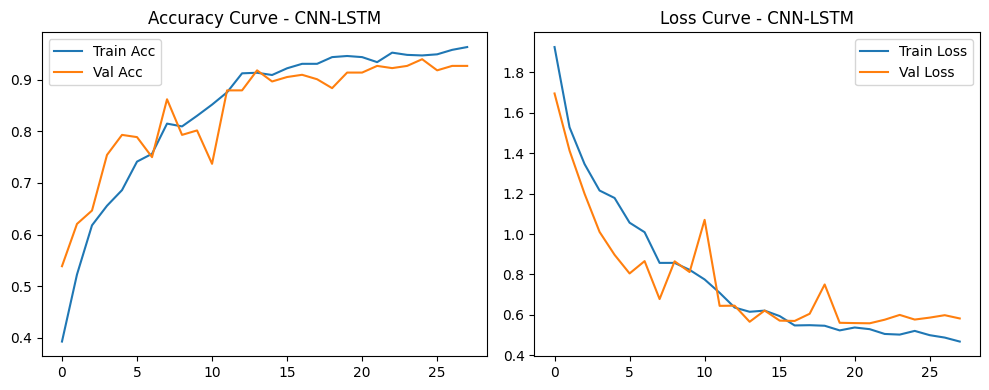

💾 Model saved as CNN_LSTM_asd_behavior_model.h5


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Load processed data
try:
    X_train = np.load("X_train.npy")
    X_test = np.load("X_test.npy")
    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    raise FileNotFoundError("❌ One or more .npy files are missing. Ensure X_train.npy, X_test.npy, y_train.npy, y_test.npy exist.")

print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Unique classes in training data: {np.unique(y_train)}")


# Encode class labels
le = LabelEncoder()
y_train_enc = tf.keras.utils.to_categorical(le.fit_transform(y_train))
y_test_enc = tf.keras.utils.to_categorical(le.transform(y_test))

num_classes = y_train_enc.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2])

# Convert class names to strings (to avoid sklearn len() error)
class_names = [str(c) for c in le.classes_]
print("\nDetected Classes:", class_names)
print("Number of classes:", num_classes)


# Build CNN-LSTM Model
model = Sequential([
    Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'cnn_lstm_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


# Train Model
history = model.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=40,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)


# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


# Confusion Matrix + Classification Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN-LSTM Model")
plt.show()

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# Plot Training Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - CNN-LSTM")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - CNN-LSTM")
plt.legend()
plt.tight_layout()
plt.show()


# Save Model
model.save("CNN_LSTM_asd_behavior_model.h5")
print("💾 Model saved as CNN_LSTM_asd_behavior_model.h5")

Data loaded successfully!
Original shape: (289, 150, 33, 2)
Train shape: (231, 150, 33, 2) Test shape: (58, 150, 33, 2)
Number of Classes: 5
Classes: ['Action_videos' 'Still_videos' 'armFlapping' 'headBanging' 'spinning']

Reshaped:
X_train: (231, 150, 33, 2)
X_test: (58, 150, 33, 2)
Model: "ST-GCN_ASD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 33, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.einsum_3 (TFOpLambda)       (None, 150, 33, 2)   0           ['input_2[0][0]']                
                                                                                                  
 c

 obalAveragePooling2D)                                                                            
                                                                                                  
 dropout_17 (Dropout)           (None, 256)          0           ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
 dense_7 (Dense)                (None, 5)            1285        ['dropout_17[0][0]']             
                                                                                                  
Total params: 860,741
Trainable params: 859,845
Non-trainable params: 896
__________________________________________________________________________________________________
Epoch 1/40
15/15 [==============================] - 58s 4s/step - loss: 1.8474 - accuracy: 0.2771 - val_loss: 1.9559 - val_accuracy: 0

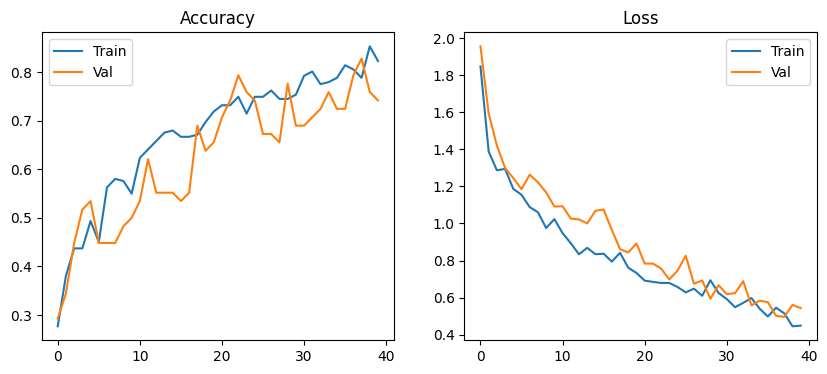

2/2 [==============================] - 7s 3s/step

Classification Report:

               precision    recall  f1-score   support

Action_videos       0.50      0.92      0.65        12
 Still_videos       1.00      0.33      0.50         9
  armFlapping       0.62      0.45      0.53        11
  headBanging       0.92      0.92      0.92        13
     spinning       1.00      0.92      0.96        13

     accuracy                           0.74        58
    macro avg       0.81      0.71      0.71        58
 weighted avg       0.81      0.74      0.73        58



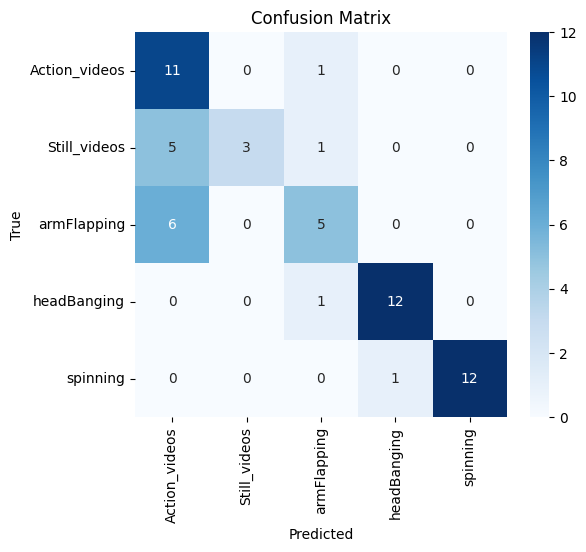


💾 Model saved as stgcn_asd_behavior_model.h5


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Load Preprocessed Data
X = np.load("X_data.npy")     # shape: (1156, 150, 66)
y = np.load("y_labels.npy")   # class labels 

print("Data loaded successfully!")
print("Original shape:", X.shape)

# Encode class labels
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(y))
num_classes = y_enc.shape[1]
classes = le.classes_

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Number of Classes:", num_classes)
print("Classes:", classes)


# Reshape Input for ST-GCN
# 66 features = 33 joints × 2 coordinates
num_joints = 33
num_coords = 2

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_joints, num_coords))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], num_joints, num_coords))

print("\nReshaped:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


# Build Graph Adjacency Matrix (for joints)
def build_adjacency(num_joints):
    A = np.eye(num_joints)
    for i in range(num_joints - 1):
        A[i, i + 1] = 1
        A[i + 1, i] = 1
    # Simple chain-like adjacency
    return A.astype(np.float32)

A = build_adjacency(num_joints)


# Define ST-GCN Building Block
def st_gcn_block(x, A, out_channels, kernel_size=(3, 3), stride=1, dropout_rate=0.25):
    # Spatial Graph Convolution (approximation)
    x_spatial = tf.einsum('ntvc,vw->ntwc', x, A)  # Aggregate using adjacency
    x_spatial = tf.keras.layers.Conv2D(out_channels, (1, 1), padding='same')(x_spatial)
    
    # Temporal Convolution
    x_temporal = Conv2D(out_channels, kernel_size, strides=(stride, 1), padding='same')(x_spatial)
    x_temporal = BatchNormalization()(x_temporal)
    x_temporal = Activation('relu')(x_temporal)
    x_temporal = Dropout(dropout_rate)(x_temporal)
    
    # Residual connection
    if x.shape[-1] != out_channels:
        x_res = Conv2D(out_channels, (1, 1), padding='same')(x)
    else:
        x_res = x

    x_out = Add()([x_temporal, x_res])
    x_out = Activation('relu')(x_out)
    return x_out

# Build ST-GCN Model
def build_stgcn(input_shape, num_classes, A):
    inputs = Input(shape=input_shape)
    x = st_gcn_block(inputs, A, 64)
    x = st_gcn_block(x, A, 128)
    x = st_gcn_block(x, A, 256)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name="ST-GCN_ASD")
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_stgcn(input_shape, num_classes, A)
model.summary()


# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=16,
    verbose=1
)


# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot accuracy/loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.show()


# Classification Report & Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Save Model
model.save("stgcn_asd_behavior_model.h5")
print("\n💾 Model saved as stgcn_asd_behavior_model.h5")

Original shapes:
X_train: (924, 150, 66)
X_test: (232, 150, 66)
✅ Reshaped for 3D CNN:
X_train_3d: (924, 150, 66, 1, 1)
X_test_3d: (232, 150, 66, 1, 1)
Num classes: 5
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 150, 66, 1, 32)    896       
                                                                 
 batch_normalization_22 (Bat  (None, 150, 66, 1, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 75, 33, 1, 32)    0         
 g3D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 75, 33, 1, 32)     0         
                                                                 
 conv3d_23 (Conv3D)

Epoch 22/60

Epoch 22: val_accuracy did not improve from 0.86207
116/116 - 56s - loss: 0.2934 - accuracy: 0.9102 - val_loss: 0.5397 - val_accuracy: 0.8448 - lr: 5.0000e-05 - 56s/epoch - 482ms/step
Epoch 23/60

Epoch 23: val_accuracy did not improve from 0.86207
116/116 - 57s - loss: 0.2513 - accuracy: 0.9210 - val_loss: 0.6652 - val_accuracy: 0.8190 - lr: 5.0000e-05 - 57s/epoch - 488ms/step
Epoch 24/60

Epoch 24: val_accuracy did not improve from 0.86207
116/116 - 56s - loss: 0.2566 - accuracy: 0.9329 - val_loss: 0.6799 - val_accuracy: 0.7931 - lr: 5.0000e-05 - 56s/epoch - 480ms/step
Epoch 25/60

Epoch 25: val_accuracy did not improve from 0.86207
116/116 - 121s - loss: 0.2377 - accuracy: 0.9383 - val_loss: 0.7220 - val_accuracy: 0.7845 - lr: 5.0000e-05 - 121s/epoch - 1s/step
Epoch 26/60
Restoring model weights from the end of the best epoch: 16.

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 26: val_accuracy did not improve from 0.86207
116/116 - 

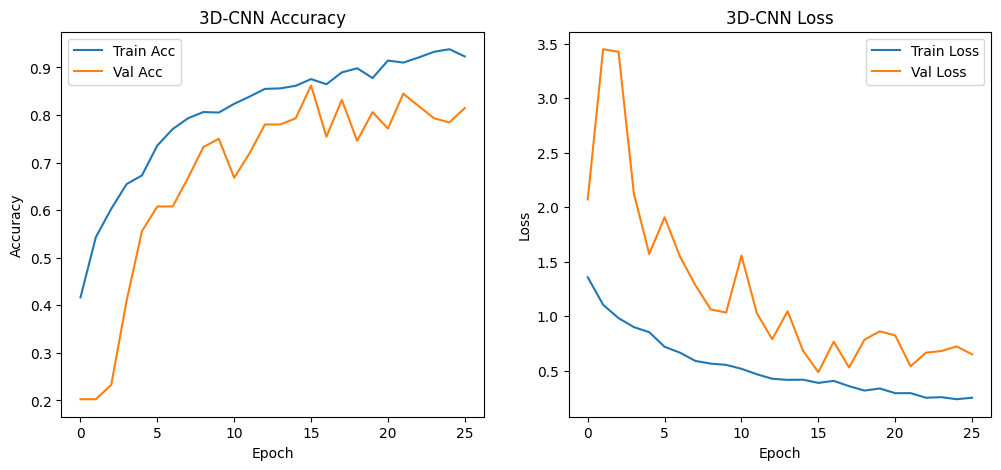

8/8 [==============================] - 4s 488ms/step


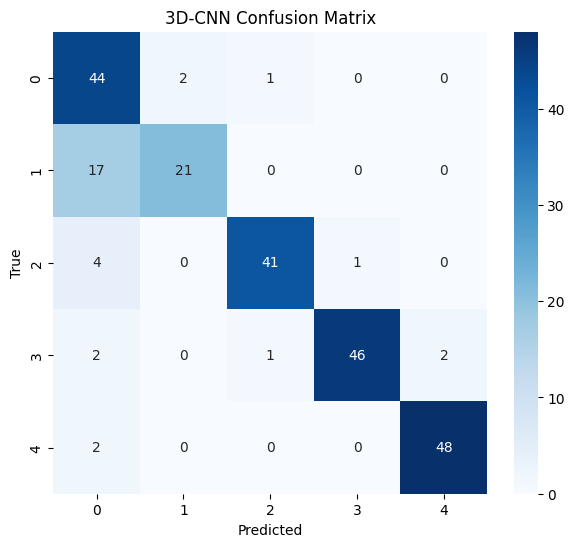


Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.94      0.76        47
           1       0.91      0.55      0.69        38
           2       0.95      0.89      0.92        46
           3       0.98      0.90      0.94        51
           4       0.96      0.96      0.96        50

    accuracy                           0.86       232
   macro avg       0.89      0.85      0.85       232
weighted avg       0.89      0.86      0.86       232



In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Prepare Dataset
print("Original shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# Normalize (z-score)
X_train = (X_train - np.mean(X_train)) / (np.std(X_train) + 1e-8)
X_test  = (X_test - np.mean(X_test)) / (np.std(X_test) + 1e-8)

# Reshape for Conv3D: (batch, frames, joints, depth, channels)
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1, 1))
X_test_3d  = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1))

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("✅ Reshaped for 3D CNN:")
print("X_train_3d:", X_train_3d.shape)
print("X_test_3d:", X_test_3d.shape)
print("Num classes:", num_classes)


# Build 3D-CNN Model
def build_3dcnn(input_shape, num_classes):
    l2_reg = regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Conv3D(32, (3,3,3), activation='relu', padding='same',
                      kernel_regularizer=l2_reg, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2,2,1)),
        layers.Dropout(0.2),

        layers.Conv3D(64, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2,2,1)),
        layers.Dropout(0.3),

        layers.Conv3D(128, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2,2,1)),
        layers.Dropout(0.4),

        layers.Conv3D(256, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu', kernel_regularizer=l2_reg),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = X_train_3d.shape[1:]
model_3dcnn = build_3dcnn(input_shape, num_classes)
model_3dcnn.summary()


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_3dcnn_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)


# Train Model
history = model_3dcnn.fit(
    X_train_3d, y_train_cat,
    validation_data=(X_test_3d, y_test_cat),
    epochs=60,
    batch_size=8,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# Save Model
model_3dcnn.save("final_3dcnn_model.h5")
print("✅ Model saved as final_3dcnn_model.h5")

# Evaluate
test_loss, test_acc = model_3dcnn.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\n🧪 Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")

# Plot Metrics
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("3D-CNN Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("3D-CNN Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()


# Confusion Matrix + Report
y_pred = np.argmax(model_3dcnn.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("3D-CNN Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks


num_classes = len(np.unique(y_train))
print("Classes:", num_classes)

# Normalize
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))


# Transformer Encoder Block (improved)
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
    # Multi-Head Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(inputs, inputs)
    attn_output = layers.Add()([inputs, attn_output])
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output)

    # Feed Forward
    ffn = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    ffn_output = layers.Add()([attn_output, ffn])
    return layers.LayerNormalization(epsilon=1e-6)(ffn_output)


# Model Definition
def build_stronger_transformer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Convolution feature extractor
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x)

    # Learnable positional encoding
    seq_len = input_shape[0]
    pos_encoding = tf.Variable(tf.random.normal([seq_len, x.shape[-1]]), trainable=True)
    x = x + pos_encoding

    # Transformer Encoder Stack
    for _ in range(4):
        x = transformer_encoder(x, num_heads=8, key_dim=64, ff_dim=256, dropout=0.2)

    # Global average pooling + Dense head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Compile and Train
model = build_stronger_transformer((150, 66), num_classes)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")

Classes: 5
Epoch 1/150
58/58 [==============================] - 52s 708ms/step - loss: 1.6758 - accuracy: 0.2348 - val_loss: 1.6422 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 2/150
58/58 [==============================] - 38s 658ms/step - loss: 1.6517 - accuracy: 0.2002 - val_loss: 1.6100 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 3/150
58/58 [==============================] - 39s 672ms/step - loss: 1.6393 - accuracy: 0.1959 - val_loss: 1.6191 - val_accuracy: 0.1983 - lr: 1.0000e-04
Epoch 4/150
58/58 [==============================] - 39s 674ms/step - loss: 1.6272 - accuracy: 0.2035 - val_loss: 1.6065 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 5/150
58/58 [==============================] - 39s 670ms/step - loss: 1.6295 - accuracy: 0.2186 - val_loss: 1.6057 - val_accuracy: 0.2155 - lr: 1.0000e-04
Epoch 6/150
58/58 [==============================] - 39s 670ms/step - loss: 1.6255 - accuracy: 0.1959 - val_loss: 1.6085 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 7/150
58/58 [====

Epoch 50/150
58/58 [==============================] - 38s 657ms/step - loss: 1.2308 - accuracy: 0.4502 - val_loss: 1.6552 - val_accuracy: 0.3793 - lr: 1.2500e-05
Epoch 51/150
58/58 [==============================] - 38s 656ms/step - loss: 1.2256 - accuracy: 0.4361 - val_loss: 1.6750 - val_accuracy: 0.3621 - lr: 1.2500e-05
Epoch 52/150
58/58 [==============================] - 38s 659ms/step - loss: 1.2388 - accuracy: 0.4351 - val_loss: 1.6363 - val_accuracy: 0.3922 - lr: 6.2500e-06
Epoch 53/150
58/58 [==============================] - 37s 645ms/step - loss: 1.2161 - accuracy: 0.4318 - val_loss: 1.6674 - val_accuracy: 0.3836 - lr: 6.2500e-06
Epoch 54/150
58/58 [==============================] - 38s 664ms/step - loss: 1.2118 - accuracy: 0.4437 - val_loss: 1.6239 - val_accuracy: 0.4052 - lr: 6.2500e-06
Epoch 55/150
58/58 [==============================] - 39s 676ms/step - loss: 1.2080 - accuracy: 0.4437 - val_loss: 1.6463 - val_accuracy: 0.4052 - lr: 6.2500e-06
Epoch 56/150
8/8 [==========

X_test shape: (232, 150, 66)
y_test shape: (232,)

🔹 Evaluating GRU...
8/8 [==============================] - 5s 66ms/step
✅ Accuracy: 90.52%
✅ Precision: 90.51%
✅ Recall: 90.52%
✅ F1-score: 90.35%

Classification Report:
              precision    recall  f1-score   support

           0      0.816     0.851     0.833        47
           1      0.903     0.737     0.812        38
           2      0.894     0.913     0.903        46
           3      0.943     0.980     0.962        51
           4      0.962     1.000     0.980        50

    accuracy                          0.905       232
   macro avg      0.904     0.896     0.898       232
weighted avg      0.905     0.905     0.904       232



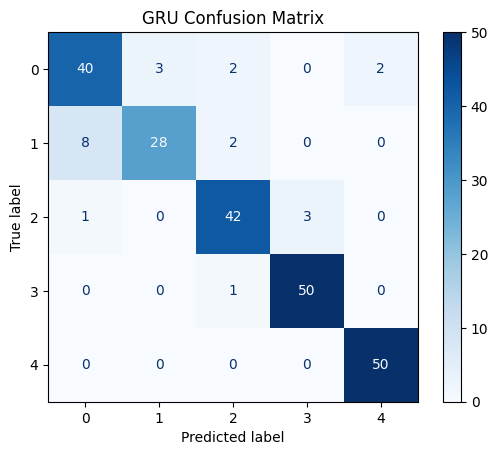


🔹 Evaluating LSTM...
8/8 [==============================] - 4s 88ms/step
✅ Accuracy: 85.78%
✅ Precision: 85.49%
✅ Recall: 85.78%
✅ F1-score: 85.46%

Classification Report:
              precision    recall  f1-score   support

           0      0.756     0.660     0.705        47
           1      0.757     0.737     0.747        38
           2      0.917     0.957     0.936        46
           3      0.862     0.980     0.917        51
           4      0.958     0.920     0.939        50

    accuracy                          0.858       232
   macro avg      0.850     0.851     0.849       232
weighted avg      0.855     0.858     0.855       232



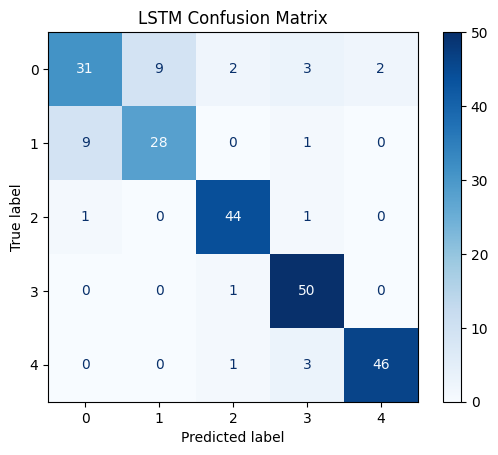


🔹 Evaluating BiLSTM...
8/8 [==============================] - 3s 141ms/step
✅ Accuracy: 95.69%
✅ Precision: 95.67%
✅ Recall: 95.69%
✅ F1-score: 95.60%

Classification Report:
              precision    recall  f1-score   support

           0      0.935     0.915     0.925        47
           1      0.941     0.842     0.889        38
           2      1.000     1.000     1.000        46
           3      0.944     1.000     0.971        51
           4      0.962     1.000     0.980        50

    accuracy                          0.957       232
   macro avg      0.956     0.951     0.953       232
weighted avg      0.957     0.957     0.956       232



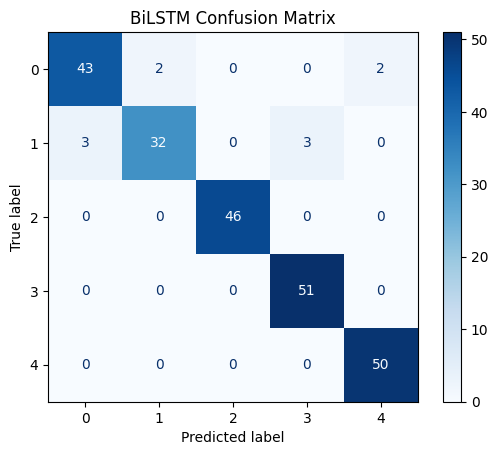


🔹 Evaluating CNN-LSTM...
8/8 [==============================] - 1s 25ms/step
✅ Accuracy: 92.67%
✅ Precision: 92.67%
✅ Recall: 92.67%
✅ F1-score: 92.66%

Classification Report:
              precision    recall  f1-score   support

           0      0.854     0.872     0.863        47
           1      0.838     0.816     0.827        38
           2      0.957     0.957     0.957        46
           3      0.980     0.980     0.980        51
           4      0.980     0.980     0.980        50

    accuracy                          0.927       232
   macro avg      0.922     0.921     0.921       232
weighted avg      0.927     0.927     0.927       232



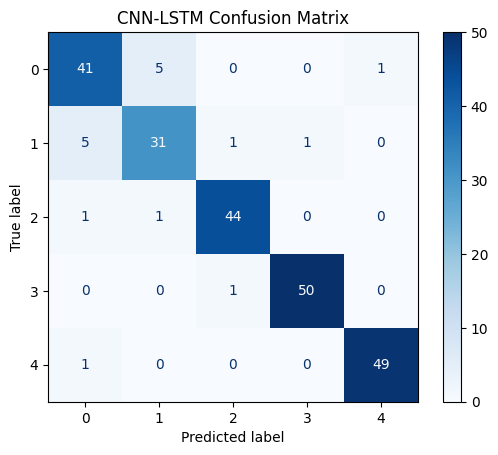


🔹 Evaluating ST-GCN...
⚠️ Error evaluating ST-GCN: Exception encountered when calling layer 'tf.einsum_3' (type TFOpLambda).

Got 0 inputs for equation "ntvc,vw->ntwc", expecting 2

Call arguments received by layer 'tf.einsum_3' (type TFOpLambda):
  • equation='ntvc,vw->ntwc'
  • inputs=<class 'inspect._empty'>
  • kwargs=<class 'inspect._empty'>

🔹 Evaluating 3D-CNN...
8/8 [==============================] - 2s 216ms/step
✅ Accuracy: 86.21%
✅ Precision: 88.98%
✅ Recall: 86.21%
✅ F1-score: 86.24%

Classification Report:
              precision    recall  f1-score   support

           0      0.638     0.936     0.759        47
           1      0.913     0.553     0.689        38
           2      0.953     0.891     0.921        46
           3      0.979     0.902     0.939        51
           4      0.960     0.960     0.960        50

    accuracy                          0.862       232
   macro avg      0.889     0.848     0.853       232
weighted avg      0.890     0.862     0.

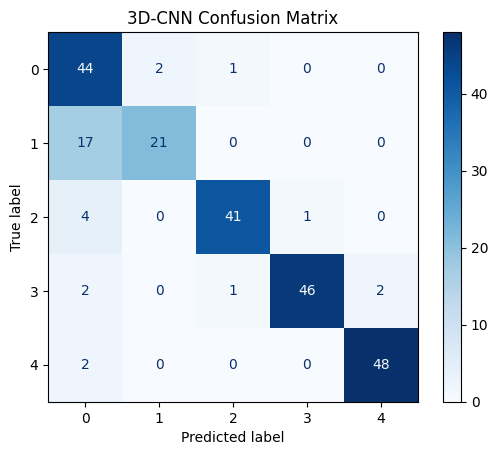


✅ Comparative Results:

      Model  Accuracy  Precision    Recall  F1-Score
0       GRU  0.905172   0.905114  0.905172  0.903507
1      LSTM  0.857759   0.854923  0.857759  0.854649
2    BiLSTM  0.956897   0.956651  0.956897  0.956046
3  CNN-LSTM  0.926724   0.926654  0.926724  0.926645
4    3D-CNN  0.862069   0.889836  0.862069  0.862408


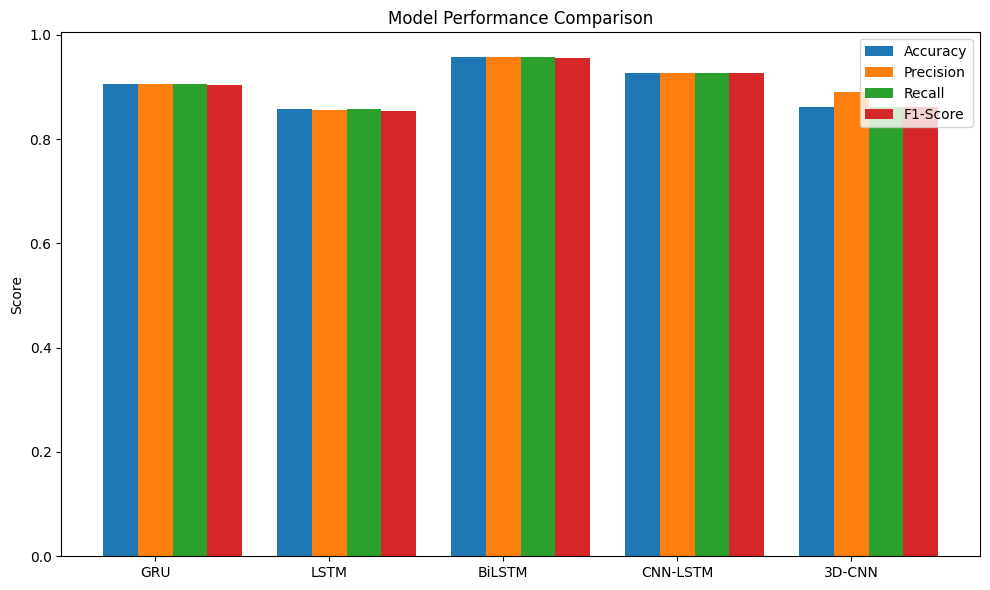

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# If labels are one-hot encoded
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# Model filenames
model_files = {
    "GRU":       "gru_asd_neutral_model.h5",
    "LSTM":      "lstm_asd_neutral_model.h5",
    "BiLSTM":    "BiLSTM_asd_behavior_model.h5",
    "CNN-LSTM":  "CNN_LSTM_asd_behavior_model.h5",
    "ST-GCN":    "stgcn_asd_behavior_model.h5",
    "3D-CNN":    "final_3dcnn_model.h5"
}

# Custom ST-GCN layer definition
A = np.eye(33, dtype=np.float32)  # replace with your real adjacency

class STGCNLayer(tf.keras.layers.Layer):
    def __init__(self, A, out_channels=64, **kwargs):
        super().__init__(**kwargs)
        self.A = tf.constant(A, dtype=tf.float32)
        self.conv = tf.keras.layers.Conv2D(out_channels, (1, 1), padding='same')

    def call(self, x):
        x_spatial = tf.einsum('ntvc,vw->ntwc', x, self.A)
        return tf.nn.relu(self.conv(x_spatial))

custom_objects = {'STGCNLayer': STGCNLayer}

# Evaluate all models
results = []

for name, path in model_files.items():
    print(f"\n🔹 Evaluating {name}...")

    try:
        # Load model
        model = load_model(path, compile=False, custom_objects=custom_objects)

        # Adjust input shape for each model
        if name == "ST-GCN":
            X_input = X_test.reshape((-1, 150, 33, 2)) 
        elif name == "3D-CNN":
            X_input = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1))
        else:
            X_input = X_test

        # Predict
        preds = model.predict(X_input, verbose=1)
        y_pred = np.argmax(preds, axis=1)
        y_true = y_test

        # Metrics 
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        print(f"✅ Accuracy: {acc*100:.2f}%")
        print(f"✅ Precision: {prec*100:.2f}%")
        print(f"✅ Recall: {rec*100:.2f}%")
        print(f"✅ F1-score: {f1*100:.2f}%")

        # Append results
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })

        # Classification report 
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3))

        #  Confusion matrix 
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{name} Confusion Matrix")
        plt.show()

    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")

# Tabulate results
if results:
    results_df = pd.DataFrame(results)
    print("\n✅ Comparative Results:\n")
    print(results_df)

    # Plot comparison graph
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    indices = np.arange(len(results_df))

    plt.bar(indices, results_df['Accuracy'], bar_width, label='Accuracy')
    plt.bar(indices + bar_width, results_df['Precision'], bar_width, label='Precision')
    plt.bar(indices + 2 * bar_width, results_df['Recall'], bar_width, label='Recall')
    plt.bar(indices + 3 * bar_width, results_df['F1-Score'], bar_width, label='F1-Score')

    plt.xticks(indices + bar_width, results_df['Model'])
    plt.ylabel("Score")
    plt.title("Model Performance Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No valid results were collected. Check for model loading or shape errors.")